## Introduction

In this challenge, we will be tackling the retention prediction problem on a very unique and interesting group of subscribers, Coursera learners! On Coursera, learners can subscribe to sets of courses in order to gain full access to graded assignments, hands-on projects, and course completion certificates. One of the most common ways that learners subscribe to content is via [Specialization Subscriptions](https://www.coursera.support/s/article/216348103-Coursera-subscriptions?language=en_US#specialization), which give learners unlimited access to the courses in a specific specialization on a month-to-month basis.

## Task
Imagine that you are a new data scientist at Coursera and you are tasked with building a model that can predict which existing specialization subscribers will continue their subscriptions for another month. The dataset is a sample of subscriptions that were initiated in 2021, all snapshotted at a particular date before the subscription was cancelled. 

Regardless the reason, Coursera has a vested interest in understanding the likelihood of each individual learner to retain in their subscription so that resources can be allocated appropriately to support learners across the various stages of their learning journeys. In this challenge, you will use your machine learning toolkit to do just that!

To determine your final score, we will compare your predicted_probability predictions to the source of truth labels for the observations in test.csv and calculate the ROC AUC. We choose this metric because we not only want to be able to predict which subscriptions will be retained, but also want a well-calibrated likelihood score that can be used to target interventions and support most accurately.

In [1]:
# Import basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv("train.csv")
df_train.head()

,subscription_id,observation_dt,is_retained,specialization_id,cnt_courses_in_specialization,specialization_domain,is_professional_certificate,is_gateway_certificate,learner_days_since_registration,learner_country_group,...,cnt_enrollments_completed_during_payment_period,cnt_enrollments_active_during_payment_period,cnt_items_completed_during_payment_period,cnt_graded_items_completed_during_payment_period,is_active_capstone_during_pay_period,sum_hours_learning_before_payment_period,sum_hours_learning_during_payment_period,cnt_days_active_before_payment_period,cnt_days_active_during_payment_period,cnt_days_since_last_activity
0,--rKikbGEeyQHQqIvaM5IQ,2022-05-04,1.0,kr43OcbTEeqeNBKhfgCLyw,8.0,Data Science,True,True,2321.0,Northern Europe,...,0.0,0.0,0.0,0.0,False,73.783333,0.000000,68.0,0.0,20.0
1,-0XGzEq2EeyimBISGRuNeQ,2021-11-30,0.0,Q0Fc_Yl0EeqdTApgQ4tM7Q,6.0,Data Science,True,False,612.0,Northern Europe,...,0.0,0.0,0.0,0.0,False,0.850000,0.000000,7.0,2.0,0.0
2,-1P9kOb6EeuRugq1Liq62w,2021-08-13,0.0,9kmimrDIEeqxzQqieMm42w,6.0,Business,True,True,27.0,Australia and New Zealand,...,0.0,1.0,12.0,2.0,False,1.833333,2.983333,2.0,1.0,18.0
3,-2ifTJZbEeuIuRKpAhovaw,2021-08-03,1.0,7lHCSlFIEeeffRIHljDI_g,5.0,Information Technology,True,True,120.0,United States,...,0.0,2.0,83.0,9.0,False,18.450000,7.100000,18.0,4.0,3.0
4,-5YKZbchEeufeAq6C_fAOw,2021-06-04,0.0,kr43OcbTEeqeNBKhfgCLyw,8.0,Data Science,True,True,1228.0,India,...,1.0,1.0,61.0,4.0,False,29.566667,15.250000,18.0,8.0,1.0


In [3]:
df_test = pd.read_csv("test.csv")
df_test.head()

,subscription_id,observation_dt,specialization_id,cnt_courses_in_specialization,specialization_domain,is_professional_certificate,is_gateway_certificate,learner_days_since_registration,learner_country_group,learner_gender,...,cnt_enrollments_completed_during_payment_period,cnt_enrollments_active_during_payment_period,cnt_items_completed_during_payment_period,cnt_graded_items_completed_during_payment_period,is_active_capstone_during_pay_period,sum_hours_learning_before_payment_period,sum_hours_learning_during_payment_period,cnt_days_active_before_payment_period,cnt_days_active_during_payment_period,cnt_days_since_last_activity
0,-1flsPG4EeuOTBLG4RY78Q,2021-08-26,kr43OcbTEeqeNBKhfgCLyw,8,Data Science,True,True,26,Southeast Asia,female,...,0,0,0,0,False,3.633333,0.0,2,0,20
1,-3jgpo3XEeuquA5bylYGqQ,2021-09-16,kr43OcbTEeqeNBKhfgCLyw,8,Data Science,True,True,1781,United States,unknown,...,0,0,0,0,False,17.133333,0.0,19,0,87
2,-4iSgbBhEeutEwol7kuJnw,2021-07-13,fq9UWMbTEeqpthJ2RmWGow,6,Business,True,True,279,United States,female,...,0,0,0,0,False,11.433333,0.0,10,0,42
3,-D1ayv64Eeuw4w5IkZJKbw,2021-09-01,51UYuPK7EeiqMA5HyBcTjA,4,Language Learning,False,False,645,Non-Brazil Latin America,female,...,0,0,0,0,False,0.500000,0.0,1,0,16
4,-DJEc-L5Eeub2BLESLBCkw,2021-09-29,7lHCSlFIEeeffRIHljDI_g,5,Information Technology,True,True,81,United States,male,...,0,0,0,0,False,19.800000,0.0,18,0,22


In [4]:
print(f' Shape of train dataset: {df_train.shape}')
print(f' Shape of test dataset: {df_test.shape}')

 Shape of train dataset: (413955, 37)
 Shape of test dataset: (217921, 36)


### Explore, Clean, Transform, and Visualize the Data

In [5]:
#data types and non null values
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413955 entries, 0 to 413954
Data columns (total 37 columns):
 #   Column                                            Non-Null Count   Dtype  
---  ------                                            --------------   -----  
 0   subscription_id                                   413955 non-null  object 
 1   observation_dt                                    413955 non-null  object 
 2   is_retained                                       413954 non-null  float64
 3   specialization_id                                 413954 non-null  object 
 4   cnt_courses_in_specialization                     413954 non-null  float64
 5   specialization_domain                             413953 non-null  object 
 6   is_professional_certificate                       413954 non-null  object 
 7   is_gateway_certificate                            413954 non-null  object 
 8   learner_days_since_registration                   413954 non-null  float64
 9   lear

In [6]:
#descriptive statistic
df_train.describe()

,is_retained,cnt_courses_in_specialization,learner_days_since_registration,learner_cnt_other_courses_active,learner_cnt_other_courses_paid_active,learner_cnt_other_courses_items_completed,learner_cnt_other_courses_paid_items_completed,learner_cnt_other_transactions_past,learner_other_revenue,subscription_period_order,...,cnt_enrollments_started_during_payment_period,cnt_enrollments_completed_during_payment_period,cnt_enrollments_active_during_payment_period,cnt_items_completed_during_payment_period,cnt_graded_items_completed_during_payment_period,sum_hours_learning_before_payment_period,sum_hours_learning_during_payment_period,cnt_days_active_before_payment_period,cnt_days_active_during_payment_period,cnt_days_since_last_activity
count,413954.000000,413954.000000,413954.000000,413954.000000,413954.000000,413954.000000,413954.000000,413954.000000,413954.000000,413954.000000,...,413954.000000,413954.000000,413954.000000,413954.000000,413954.000000,413954.000000,413954.000000,413954.000000,413954.000000,413954.000000
mean,0.543664,5.926637,745.106720,5.421735,1.281524,114.289404,62.943846,1.966615,101.281442,2.477217,...,0.285387,0.235050,0.681228,21.015035,1.743264,15.596039,3.474727,12.474867,2.585720,29.130662
std,0.498090,1.759559,950.799959,13.819034,3.743262,303.469641,194.269892,6.517240,353.679851,2.352873,...,0.720924,0.655434,0.949700,50.313201,4.422363,27.338616,8.412757,18.937620,4.062454,52.340933
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,5.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.150000,0.000000,2.000000,0.000000,1.000000
50%,1.000000,6.000000,279.000000,1.000000,0.000000,4.000000,0.000000,0.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,6.183333,0.000000,6.000000,1.000000,9.000000
75%,1.000000,7.000000,1109.000000,4.000000,1.000000,90.000000,13.000000,1.000000,49.000000,3.000000,...,0.000000,0.000000,1.000000,20.000000,2.000000,18.633333,3.533333,15.000000,4.000000,32.000000
max,1.000000,13.000000,3857.000000,604.000000,215.000000,19439.000000,6912.000000,474.000000,24069.920000,19.000000,...,13.000000,10.000000,11.000000,1043.000000,149.000000,2375.683333,1393.300000,616.000000,31.000000,548.000000


In [7]:
#duplicate rows
df_train.duplicated().sum()

0

In [8]:
#total null values
df_train.isnull().sum()

subscription_id                                     0
observation_dt                                      0
is_retained                                         1
specialization_id                                   1
cnt_courses_in_specialization                       1
specialization_domain                               2
is_professional_certificate                         1
is_gateway_certificate                              1
learner_days_since_registration                     1
learner_country_group                               1
learner_gender                                      1
learner_cnt_other_courses_active                    1
learner_cnt_other_courses_paid_active               1
learner_cnt_other_courses_items_completed           1
learner_cnt_other_courses_paid_items_completed      1
learner_cnt_other_transactions_past                 1
learner_other_revenue                               1
subscription_period_order                           1
days_since_last_payment     

In [9]:
#Since dataset is fairly large, we will remove null row because all null values are in a single row
df_train = df_train[~df_train.isna().any(axis=1)]
df_train

,subscription_id,observation_dt,is_retained,specialization_id,cnt_courses_in_specialization,specialization_domain,is_professional_certificate,is_gateway_certificate,learner_days_since_registration,learner_country_group,...,cnt_enrollments_completed_during_payment_period,cnt_enrollments_active_during_payment_period,cnt_items_completed_during_payment_period,cnt_graded_items_completed_during_payment_period,is_active_capstone_during_pay_period,sum_hours_learning_before_payment_period,sum_hours_learning_during_payment_period,cnt_days_active_before_payment_period,cnt_days_active_during_payment_period,cnt_days_since_last_activity
0,--rKikbGEeyQHQqIvaM5IQ,2022-05-04,1.0,kr43OcbTEeqeNBKhfgCLyw,8.0,Data Science,True,True,2321.0,Northern Europe,...,0.0,0.0,0.0,0.0,False,73.783333,0.000000,68.0,0.0,20.0
1,-0XGzEq2EeyimBISGRuNeQ,2021-11-30,0.0,Q0Fc_Yl0EeqdTApgQ4tM7Q,6.0,Data Science,True,False,612.0,Northern Europe,...,0.0,0.0,0.0,0.0,False,0.850000,0.000000,7.0,2.0,0.0
2,-1P9kOb6EeuRugq1Liq62w,2021-08-13,0.0,9kmimrDIEeqxzQqieMm42w,6.0,Business,True,True,27.0,Australia and New Zealand,...,0.0,1.0,12.0,2.0,False,1.833333,2.983333,2.0,1.0,18.0
3,-2ifTJZbEeuIuRKpAhovaw,2021-08-03,1.0,7lHCSlFIEeeffRIHljDI_g,5.0,Information Technology,True,True,120.0,United States,...,0.0,2.0,83.0,9.0,False,18.450000,7.100000,18.0,4.0,3.0
4,-5YKZbchEeufeAq6C_fAOw,2021-06-04,0.0,kr43OcbTEeqeNBKhfgCLyw,8.0,Data Science,True,True,1228.0,India,...,1.0,1.0,61.0,4.0,False,29.566667,15.250000,18.0,8.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413949,qaBfOhVMEeyqwg6X9_jyxQ,2021-09-18,0.0,68fXxAJgEeqJHxKP6A-i8w,5.0,Data Science,False,False,23.0,India,...,1.0,1.0,67.0,1.0,False,3.433333,3.033333,2.0,4.0,1.0
413950,qfUTFIAzEeukyg4dWWEYuw,2021-06-05,1.0,MA2cOQjlEeazygrbcvZenQ,5.0,Business,False,False,142.0,United States,...,0.0,0.0,0.0,0.0,False,4.783333,0.000000,11.0,2.0,19.0
413951,qfjlwk4LEeuoQBI_iUz8bQ,2021-01-27,0.0,oyGHLnb0EeaoxxIn6_zz2w,4.0,Computer Science,False,False,2598.0,United States,...,0.0,2.0,5.0,3.0,False,10.216667,2.583333,8.0,2.0,23.0
413952,qfnRCjb9Eeyw2QrDB7Ax2w,2022-07-06,1.0,Z6lBAk_lEee97AqCypYrLA,4.0,Business,False,False,252.0,East Asia,...,0.0,0.0,0.0,0.0,False,2.716667,0.000000,4.0,0.0,219.0


<AxesSubplot:>

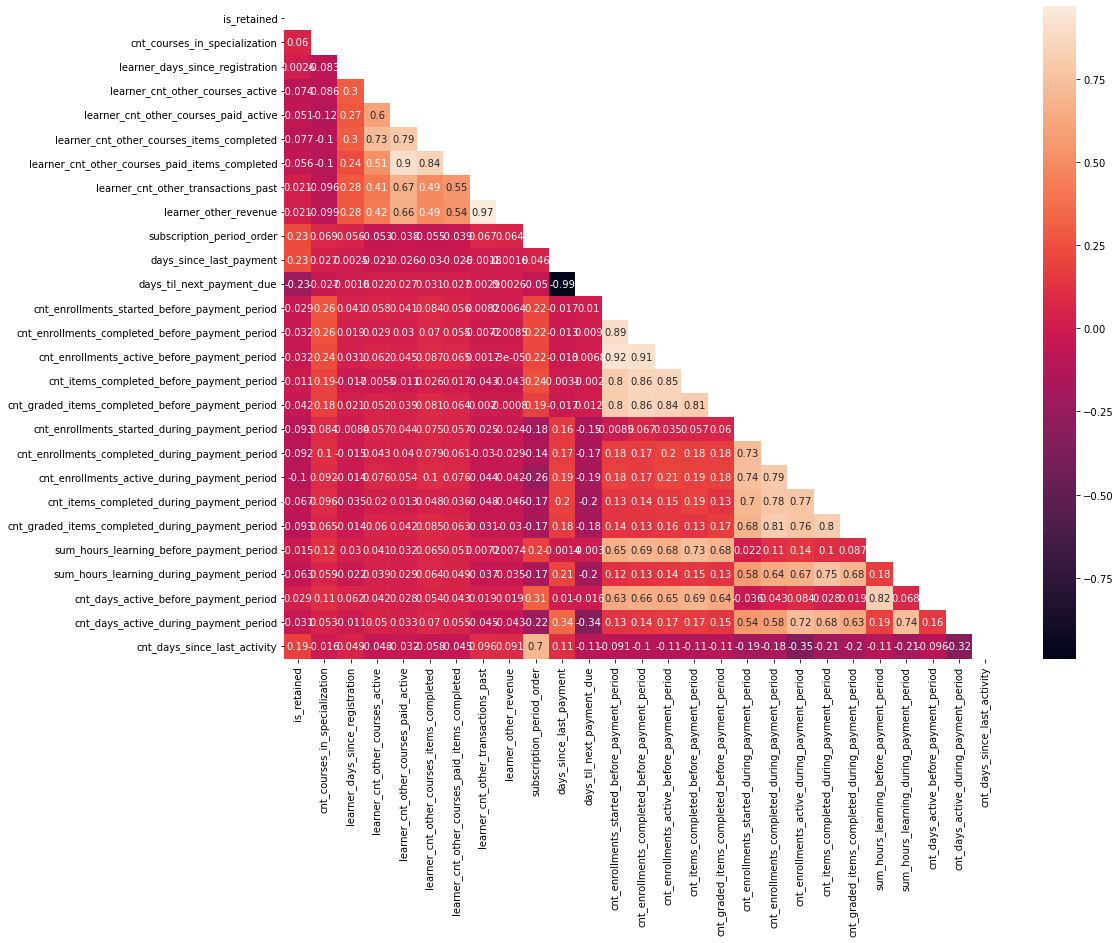

In [10]:
# heat map correlation
plt.figure(figsize=(16,12))
sns.heatmap(df_train.corr(), annot=True, mask=np.triu(df_train.corr()))

In [11]:
#check data imbalance for target variable
df_train['is_retained'].value_counts()/len(df_train.index) * 100

1.0    54.366317
0.0    45.633683
Name: is_retained, dtype: float64

In [12]:
#total number of specialization in dataset
len(df_train['specialization_id'].value_counts())

742

In [13]:
#total specialization domains in dataset
len(df_train['specialization_domain'].value_counts())

11

In [14]:
# count of user enrollment in specialization domains
df_train['specialization_domain'].value_counts(normalize=True).sort_values(ascending=False)

Data Science                        0.341594
Business                            0.237331
Computer Science                    0.180663
Information Technology              0.157136
Arts and Humanities                 0.025211
Health                              0.017628
Language Learning                   0.017043
Physical Science and Engineering    0.008098
Social Sciences                     0.007467
Personal Development                0.005706
Math and Logic                      0.002123
Name: specialization_domain, dtype: float64

In [15]:
# count of professional certificate
print(df_train['is_professional_certificate'].value_counts(normalize=True).sort_values(ascending=False))

True     0.576087
False    0.423913
Name: is_professional_certificate, dtype: float64


In [16]:
#learner days since registration
df_train['learner_days_since_registration'].describe()

count    413953.000000
mean        745.107128
std         950.801071
min           0.000000
25%          71.000000
50%         279.000000
75%        1109.000000
max        3857.000000
Name: learner_days_since_registration, dtype: float64

In [17]:
#learners across various countries
df_train['learner_country_group'].value_counts(normalize=True).sort_values(ascending=False)

United States                        0.472418
Northern Europe                      0.099627
India                                0.057726
Non-Brazil Latin America             0.055649
East Asia                            0.047356
Canada                               0.044375
Southern Europe                      0.042587
Southeast Asia                       0.033091
Africa and developing Middle East    0.030274
Eastern Europe                       0.029549
Middle East                          0.025520
Russia and neighbors                 0.021167
Australia and New Zealand            0.019113
Brazil                               0.014799
China                                0.006750
Name: learner_country_group, dtype: float64

In [18]:
# value count of learner gender on train dataset
df_train['learner_gender'].value_counts(normalize=True).sort_values(ascending=False)

male       0.438820
unknown    0.288943
female     0.269560
other      0.002677
Name: learner_gender, dtype: float64

In [19]:
# value count of learner gender on test dataset
df_test['learner_gender'].value_counts(normalize=True).sort_values(ascending=False)

male       0.440251
unknown    0.288829
female     0.268235
other      0.002684
Name: learner_gender, dtype: float64

### Prepare Data for Modelling

In [20]:
#display all columns
pd.set_option("display.max_columns", None)
df_train.head()

,subscription_id,observation_dt,is_retained,specialization_id,cnt_courses_in_specialization,specialization_domain,is_professional_certificate,is_gateway_certificate,learner_days_since_registration,learner_country_group,learner_gender,learner_cnt_other_courses_active,learner_cnt_other_courses_paid_active,learner_cnt_other_courses_items_completed,learner_cnt_other_courses_paid_items_completed,learner_cnt_other_transactions_past,learner_other_revenue,subscription_period_order,days_since_last_payment,days_til_next_payment_due,cnt_enrollments_started_before_payment_period,cnt_enrollments_completed_before_payment_period,cnt_enrollments_active_before_payment_period,cnt_items_completed_before_payment_period,cnt_graded_items_completed_before_payment_period,is_subscription_started_with_free_trial,cnt_enrollments_started_during_payment_period,cnt_enrollments_completed_during_payment_period,cnt_enrollments_active_during_payment_period,cnt_items_completed_during_payment_period,cnt_graded_items_completed_during_payment_period,is_active_capstone_during_pay_period,sum_hours_learning_before_payment_period,sum_hours_learning_during_payment_period,cnt_days_active_before_payment_period,cnt_days_active_during_payment_period,cnt_days_since_last_activity
0,--rKikbGEeyQHQqIvaM5IQ,2022-05-04,1.0,kr43OcbTEeqeNBKhfgCLyw,8.0,Data Science,True,True,2321.0,Northern Europe,female,8.0,0.0,88.0,0.0,0.0,0.00,6.0,18.0,11.0,5.0,4.0,5.0,427.0,22.0,False,0.0,0.0,0.0,0.0,0.0,False,73.783333,0.000000,68.0,0.0,20.0
1,-0XGzEq2EeyimBISGRuNeQ,2021-11-30,0.0,Q0Fc_Yl0EeqdTApgQ4tM7Q,6.0,Data Science,True,False,612.0,Northern Europe,female,52.0,2.0,209.0,75.0,1.0,49.41,1.0,1.0,28.0,1.0,0.0,1.0,13.0,3.0,True,0.0,0.0,0.0,0.0,0.0,False,0.850000,0.000000,7.0,2.0,0.0
2,-1P9kOb6EeuRugq1Liq62w,2021-08-13,0.0,9kmimrDIEeqxzQqieMm42w,6.0,Business,True,True,27.0,Australia and New Zealand,unknown,5.0,0.0,5.0,0.0,0.0,0.00,1.0,18.0,11.0,1.0,0.0,1.0,13.0,2.0,True,0.0,0.0,1.0,12.0,2.0,False,1.833333,2.983333,2.0,1.0,18.0
3,-2ifTJZbEeuIuRKpAhovaw,2021-08-03,1.0,7lHCSlFIEeeffRIHljDI_g,5.0,Information Technology,True,True,120.0,United States,male,0.0,0.0,0.0,0.0,0.0,0.00,4.0,21.0,9.0,2.0,1.0,2.0,234.0,11.0,True,1.0,0.0,2.0,83.0,9.0,False,18.450000,7.100000,18.0,4.0,3.0
4,-5YKZbchEeufeAq6C_fAOw,2021-06-04,0.0,kr43OcbTEeqeNBKhfgCLyw,8.0,Data Science,True,True,1228.0,India,unknown,0.0,0.0,0.0,0.0,0.0,0.00,1.0,10.0,20.0,3.0,1.0,3.0,109.0,7.0,True,1.0,1.0,1.0,61.0,4.0,False,29.566667,15.250000,18.0,8.0,1.0


In [21]:
#convert boolean columns to 1 and 0

bool_col = ['is_professional_certificate', 'is_gateway_certificate', 
                       'is_subscription_started_with_free_trial', 'is_active_capstone_during_pay_period']

df_train[bool_col] = df_train[bool_col].astype('int')
df_test[bool_col] = df_test[bool_col].astype('int')

In [22]:
# drop unnecessary columns
df_train = df_train.drop(['subscription_id', 'observation_dt', 'specialization_id'], axis=1)
df_test = df_test.drop(['subscription_id', 'observation_dt', 'specialization_id'], axis=1)

In [23]:
#select categorical column names
categorical = df_train.select_dtypes("object")
categorical_col = categorical.columns

#select numerical column names
numerical = df_train.select_dtypes(("int64", "float64"))
numerical_col = numerical.columns

categorical_col

Index(['specialization_domain', 'learner_country_group', 'learner_gender'], dtype='object')

In [24]:
#create dummies for categorical columns

df_train_dum = pd.get_dummies(df_train[categorical_col], drop_first=False)
df_test_dum = pd.get_dummies(df_test[categorical_col], drop_first=False)

#unlike industry standard of drop_first = True, I'll drop columns that has a least total values

In [25]:
# dummy columns
df_train_dum.columns

Index(['specialization_domain_Arts and Humanities',
       'specialization_domain_Business',
       'specialization_domain_Computer Science',
       'specialization_domain_Data Science', 'specialization_domain_Health',
       'specialization_domain_Information Technology',
       'specialization_domain_Language Learning',
       'specialization_domain_Math and Logic',
       'specialization_domain_Personal Development',
       'specialization_domain_Physical Science and Engineering',
       'specialization_domain_Social Sciences',
       'learner_country_group_Africa and developing Middle East',
       'learner_country_group_Australia and New Zealand',
       'learner_country_group_Brazil', 'learner_country_group_Canada',
       'learner_country_group_China', 'learner_country_group_East Asia',
       'learner_country_group_Eastern Europe', 'learner_country_group_India',
       'learner_country_group_Middle East',
       'learner_country_group_Non-Brazil Latin America',
       'learner_

In [26]:
#drop 'learner_gender_other' from learner-gender dummies

print(df_train_dum[['learner_gender_female',
       'learner_gender_male', 'learner_gender_other',
       'learner_gender_unknown']].sum())

df_train_dum.drop('learner_gender_other', axis=1, inplace=True)
df_test_dum.drop('learner_gender_other', axis=1, inplace=True)

learner_gender_female     111585
learner_gender_male       181651
learner_gender_other        1108
learner_gender_unknown    119609
dtype: int64


In [27]:
# drop 'learner_country_group_China' from learner-Country-group dummies

print(df_train_dum[['learner_country_group_Africa and developing Middle East',
       'learner_country_group_Australia and New Zealand',
       'learner_country_group_Brazil', 'learner_country_group_Canada',
       'learner_country_group_China', 'learner_country_group_East Asia',
       'learner_country_group_Eastern Europe', 'learner_country_group_India',
       'learner_country_group_Middle East',
       'learner_country_group_Non-Brazil Latin America',
       'learner_country_group_Northern Europe',
       'learner_country_group_Russia and neighbors',
       'learner_country_group_Southeast Asia',
       'learner_country_group_Southern Europe',
       'learner_country_group_United States']].sum().sort_values())

df_train_dum.drop('learner_country_group_China', axis=1, inplace=True)
df_test_dum.drop('learner_country_group_China', axis=1, inplace=True)

learner_country_group_China                                  2794
learner_country_group_Brazil                                 6126
learner_country_group_Australia and New Zealand              7912
learner_country_group_Russia and neighbors                   8762
learner_country_group_Middle East                           10564
learner_country_group_Eastern Europe                        12232
learner_country_group_Africa and developing Middle East     12532
learner_country_group_Southeast Asia                        13698
learner_country_group_Southern Europe                       17629
learner_country_group_Canada                                18369
learner_country_group_East Asia                             19603
learner_country_group_Non-Brazil Latin America              23036
learner_country_group_India                                 23896
learner_country_group_Northern Europe                       41241
learner_country_group_United States                        195559
dtype: int

In [28]:
# drop 'specialization_domain_Math and Logic' from specialization domain dummies

print(df_train_dum[['specialization_domain_Arts and Humanities',
       'specialization_domain_Business',
       'specialization_domain_Computer Science',
       'specialization_domain_Data Science', 'specialization_domain_Health',
       'specialization_domain_Information Technology',
       'specialization_domain_Language Learning',
       'specialization_domain_Math and Logic',
       'specialization_domain_Personal Development',
       'specialization_domain_Physical Science and Engineering',
       'specialization_domain_Social Sciences']].sum().sort_values())

df_train_dum.drop('specialization_domain_Math and Logic', axis=1, inplace=True)
df_test_dum.drop('specialization_domain_Math and Logic', axis=1, inplace=True)

specialization_domain_Math and Logic                         879
specialization_domain_Personal Development                  2362
specialization_domain_Social Sciences                       3091
specialization_domain_Physical Science and Engineering      3352
specialization_domain_Language Learning                     7055
specialization_domain_Health                                7297
specialization_domain_Arts and Humanities                  10436
specialization_domain_Information Technology               65047
specialization_domain_Computer Science                     74786
specialization_domain_Business                             98244
specialization_domain_Data Science                        141404
dtype: int64


In [29]:
# drop categorical columns from train and test dataset
df_train = df_train.drop(columns = {'specialization_domain', 'learner_country_group', 'learner_gender'}, axis=1)
df_test = df_test.drop(columns = {'specialization_domain', 'learner_country_group', 'learner_gender'}, axis=1)

In [30]:
#concat dummy columns to train and test dataset
df_train = pd.concat([df_train, df_train_dum], axis=1)
df_test = pd.concat([df_test, df_test_dum], axis=1)
df_train.head()

,is_retained,cnt_courses_in_specialization,is_professional_certificate,is_gateway_certificate,learner_days_since_registration,learner_cnt_other_courses_active,learner_cnt_other_courses_paid_active,learner_cnt_other_courses_items_completed,learner_cnt_other_courses_paid_items_completed,learner_cnt_other_transactions_past,learner_other_revenue,subscription_period_order,days_since_last_payment,days_til_next_payment_due,cnt_enrollments_started_before_payment_period,cnt_enrollments_completed_before_payment_period,cnt_enrollments_active_before_payment_period,cnt_items_completed_before_payment_period,cnt_graded_items_completed_before_payment_period,is_subscription_started_with_free_trial,cnt_enrollments_started_during_payment_period,cnt_enrollments_completed_during_payment_period,cnt_enrollments_active_during_payment_period,cnt_items_completed_during_payment_period,cnt_graded_items_completed_during_payment_period,is_active_capstone_during_pay_period,sum_hours_learning_before_payment_period,sum_hours_learning_during_payment_period,cnt_days_active_before_payment_period,cnt_days_active_during_payment_period,cnt_days_since_last_activity,specialization_domain_Arts and Humanities,specialization_domain_Business,specialization_domain_Computer Science,specialization_domain_Data Science,specialization_domain_Health,specialization_domain_Information Technology,specialization_domain_Language Learning,specialization_domain_Personal Development,specialization_domain_Physical Science and Engineering,specialization_domain_Social Sciences,learner_country_group_Africa and developing Middle East,learner_country_group_Australia and New Zealand,learner_country_group_Brazil,learner_country_group_Canada,learner_country_group_East Asia,learner_country_group_Eastern Europe,learner_country_group_India,learner_country_group_Middle East,learner_country_group_Non-Brazil Latin America,learner_country_group_Northern Europe,learner_country_group_Russia and neighbors,learner_country_group_Southeast Asia,learner_country_group_Southern Europe,learner_country_group_United States,learner_gender_female,learner_gender_male,learner_gender_unknown
0,1.0,8.0,1,1,2321.0,8.0,0.0,88.0,0.0,0.0,0.00,6.0,18.0,11.0,5.0,4.0,5.0,427.0,22.0,0,0.0,0.0,0.0,0.0,0.0,0,73.783333,0.000000,68.0,0.0,20.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,0.0,6.0,1,0,612.0,52.0,2.0,209.0,75.0,1.0,49.41,1.0,1.0,28.0,1.0,0.0,1.0,13.0,3.0,1,0.0,0.0,0.0,0.0,0.0,0,0.850000,0.000000,7.0,2.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
2,0.0,6.0,1,1,27.0,5.0,0.0,5.0,0.0,0.0,0.00,1.0,18.0,11.0,1.0,0.0,1.0,13.0,2.0,1,0.0,0.0,1.0,12.0,2.0,0,1.833333,2.983333,2.0,1.0,18.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1.0,5.0,1,1,120.0,0.0,0.0,0.0,0.0,0.0,0.00,4.0,21.0,9.0,2.0,1.0,2.0,234.0,11.0,1,1.0,0.0,2.0,83.0,9.0,0,18.450000,7.100000,18.0,4.0,3.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
4,0.0,8.0,1,1,1228.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,10.0,20.0,3.0,1.0,3.0,109.0,7.0,1,1.0,1.0,1.0,61.0,4.0,0,29.566667,15.250000,18.0,8.0,1.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


In [31]:
#create dependent and independent variables for train dataset 
y = df_train.pop('is_retained')
X = df_train

In [32]:
# split into train and test
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)

In [33]:
#from sklearn.preprocessing import MinMaxScaler

#scaler = MinMaxScaler()

#X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train),columns = X_train.columns)
#X_val_scaled = pd.DataFrame(scaler.transform(X_val),columns = X_val.columns)

In [34]:
y_train = y_train.values.reshape(-1,1)

### Feature Selection

In [35]:
import statsmodels.api as sm 
# Feature selection based on p-values and VIFs

lm = sm.GLM(y_train, sm.add_constant(X_train), family = sm.families.Binomial()).fit()
lm.summary()

# The base level model indicates a lot of insignificant variables

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:               331162
Model:                            GLM   Df Residuals:                   331104
Model Family:                Binomial   Df Model:                           57
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.9985e+05
Date:                Wed, 18 Jan 2023   Deviance:                   3.9970e+05
Time:                        00:46:19   Pearson chi2:                 3.37e+05
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1579
Covariance Type:            nonrobust                                         
===========================================================================================================================
                                                              coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------
const                                                      -0.9201      0.163     -5.646      0.000      -1.240      -0.601
cnt_courses_in_specialization                               0.0297      0.003      8.662      0.000       0.023       0.036
is_professional_certificate                                 0.0948      0.020      4.824      0.000       0.056       0.133
is_gateway_certificate                                      0.1643      0.018      8.899      0.000       0.128       0.201
learner_days_since_registration                          4.522e-05   4.44e-06     10.177      0.000    3.65e-05    5.39e-05
learner_cnt_other_courses_active                           -0.0029      0.000     -6.235      0.000      -0.004      -0.002
learner_cnt_other_courses_paid_active                      -0.0189      0.003     -6.003      0.000      -0.025      -0.013
learner_cnt_other_courses_items_completed                  -0.0003   3.43e-05     -8.796      0.000      -0.000      -0.000
learner_cnt_other_courses_paid_items_completed              0.0002   6.13e-05      2.616      0.009    4.02e-05       0.000
learner_cnt_other_transactions_past                         0.0105      0.003      4.014      0.000       0.005       0.016
learner_other_revenue                                       0.0002   4.72e-05      4.695      0.000       0.000       0.000
subscription_period_order                                   0.2466      0.004     68.654      0.000       0.240       0.254
days_since_last_payment                                     0.0356      0.004      9.730      0.000       0.028       0.043
days_til_next_payment_due                                  -0.0257      0.004     -7.036      0.000      -0.033      -0.019
cnt_enrollments_started_before_payment_period              -0.0191      0.007     -2.795      0.005      -0.032      -0.006
cnt_enrollments_completed_before_payment_period            -0.0925      0.009    -10.865      0.000      -0.109      -0.076
cnt_enrollments_active_before_payment_period               -0.0328      0.008     -4.115      0.000      -0.048      -0.017
cnt_items_completed_before_payment_period                  -0.0001   7.45e-05     -1.607      0.108      -0.000    2.63e-05
cnt_graded_items_completed_before_payment_period           -0.0002      0.001     -0.272      0.786      -0.002       0.001
is_subscription_started_with_free_trial                     0.6062      0.009     67.725      0.000       0.589       0.624
cnt_enrollments_started_during_payment_period              -0.0485      0.009     -5.130      0.000      -0.067      -0.030
cnt_enrollments_completed_during_payment_period            -0.2586      0.012    -20.827      0.000      -0

In [36]:
# Recursive feature elimination to select top 40 features out of 57 features

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

lm = LogisticRegression()
lm.fit(X_train,y_train)

rfe = RFE(lm, n_features_to_select=40)
rfe = rfe.fit(X_train, y_train)

In [37]:
del_col = X_train.columns[~rfe.support_] # to drop columns from test dataset

In [38]:
col = X_train.columns[rfe.support_]

#apply changes to both train and validation data
X_train_rfe = X_train[col]
X_val_rfe = X_val[col]

print(X_train_rfe.shape)
print(X_val_rfe.shape)

(331162, 40)
(82791, 40)


In [39]:
# checking P-values after doing 17 feature elimination

lm = sm.GLM(y_train, sm.add_constant(X_train_rfe), family = sm.families.Binomial()).fit()   # Running the linear model
lm.summary()

# we still need to take care of few more insignificant features (will do manually one-by-one)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:               331162
Model:                            GLM   Df Residuals:                   331121
Model Family:                Binomial   Df Model:                           40
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.0018e+05
Date:                Wed, 18 Jan 2023   Deviance:                   4.0035e+05
Time:                        00:47:47   Pearson chi2:                 3.37e+05
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1562
Covariance Type:            nonrobust                                         
===========================================================================================================================
                                                              coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------
const                                                       0.0520      0.079      0.660      0.509      -0.102       0.206
cnt_courses_in_specialization                               0.0282      0.003      8.426      0.000       0.022       0.035
is_professional_certificate                                 0.0890      0.020      4.558      0.000       0.051       0.127
is_gateway_certificate                                      0.1692      0.018      9.276      0.000       0.133       0.205
learner_cnt_other_courses_active                           -0.0046      0.000    -12.454      0.000      -0.005      -0.004
learner_cnt_other_courses_paid_active                      -0.0252      0.002    -14.154      0.000      -0.029      -0.022
learner_cnt_other_transactions_past                         0.0237      0.001     22.986      0.000       0.022       0.026
subscription_period_order                                   0.2320      0.002     99.139      0.000       0.227       0.237
days_til_next_payment_due                                  -0.0598      0.000   -121.627      0.000      -0.061      -0.059
cnt_enrollments_started_before_payment_period              -0.0186      0.007     -2.743      0.006      -0.032      -0.005
cnt_enrollments_completed_before_payment_period            -0.0805      0.007    -11.046      0.000      -0.095      -0.066
cnt_enrollments_active_before_payment_period               -0.0247      0.008     -3.284      0.001      -0.039      -0.010
is_subscription_started_with_free_trial                     0.5762      0.009     66.271      0.000       0.559       0.593
cnt_enrollments_started_during_payment_period              -0.0492      0.009     -5.300      0.000      -0.067      -0.031
cnt_enrollments_completed_during_payment_period            -0.2715      0.012    -22.495      0.000      -0.295      -0.248
cnt_enrollments_active_during_payment_period                0.1125      0.009     12.969      0.000       0.095       0.129
cnt_graded_items_completed_during_payment_period           -0.0246      0.002    -14.143      0.000      -0.028      -0.021
is_active_capstone_during_pay_period                       -2.9590      0.199    -14.882      0.000      -3.349      -2.569
cnt_days_active_during_payment_period                       0.0207      0.001     13.815      0.000       0.018       0.024
specialization_domain_Business                              0.0454      0.011      3.980      0.000       0.023       0.068
specialization_domain_Data Science                          0.0341      0.011      3.062      0.002       0.012       0.056
specialization_domain_Health                                0.0653      0.030      2.199      0.028       0

In [40]:
# removing 1 feature with high p-value

X_train_rfe = X_train_rfe.drop('learner_country_group_Southern Europe', axis=1)
X_val_rfe = X_val_rfe.drop('learner_country_group_Southern Europe', axis=1)

In [41]:
# rechecking p-values 

lm = sm.GLM(y_train, sm.add_constant(X_train_rfe), family = sm.families.Binomial()).fit()   # Running the linear model
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:               331162
Model:                            GLM   Df Residuals:                   331122
Model Family:                Binomial   Df Model:                           39
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.0018e+05
Date:                Wed, 18 Jan 2023   Deviance:                   4.0036e+05
Time:                        00:47:50   Pearson chi2:                 3.37e+05
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1562
Covariance Type:            nonrobust                                         
===========================================================================================================================
                                                              coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------
const                                                       0.0634      0.078      0.809      0.419      -0.090       0.217
cnt_courses_in_specialization                               0.0281      0.003      8.417      0.000       0.022       0.035
is_professional_certificate                                 0.0890      0.020      4.556      0.000       0.051       0.127
is_gateway_certificate                                      0.1687      0.018      9.252      0.000       0.133       0.204
learner_cnt_other_courses_active                           -0.0046      0.000    -12.471      0.000      -0.005      -0.004
learner_cnt_other_courses_paid_active                      -0.0252      0.002    -14.125      0.000      -0.029      -0.022
learner_cnt_other_transactions_past                         0.0237      0.001     22.980      0.000       0.022       0.026
subscription_period_order                                   0.2320      0.002     99.134      0.000       0.227       0.237
days_til_next_payment_due                                  -0.0598      0.000   -121.621      0.000      -0.061      -0.059
cnt_enrollments_started_before_payment_period              -0.0186      0.007     -2.738      0.006      -0.032      -0.005
cnt_enrollments_completed_before_payment_period            -0.0805      0.007    -11.052      0.000      -0.095      -0.066
cnt_enrollments_active_before_payment_period               -0.0245      0.008     -3.266      0.001      -0.039      -0.010
is_subscription_started_with_free_trial                     0.5764      0.009     66.299      0.000       0.559       0.593
cnt_enrollments_started_during_payment_period              -0.0493      0.009     -5.305      0.000      -0.067      -0.031
cnt_enrollments_completed_during_payment_period            -0.2714      0.012    -22.489      0.000      -0.295      -0.248
cnt_enrollments_active_during_payment_period                0.1125      0.009     12.976      0.000       0.096       0.130
cnt_graded_items_completed_during_payment_period           -0.0246      0.002    -14.135      0.000      -0.028      -0.021
is_active_capstone_during_pay_period                       -2.9591      0.199    -14.882      0.000      -3.349      -2.569
cnt_days_active_during_payment_period                       0.0207      0.001     13.811      0.000       0.018       0.024
specialization_domain_Business                              0.0454      0.011      3.976      0.000       0.023       0.068
specialization_domain_Data Science                          0.0343      0.011      3.086      0.002       0.013       0.056
specialization_domain_Health                                0.0648      0.030      2.184      0.029       0

In [42]:
# removing 1 feature with high p-value

X_train_rfe = X_train_rfe.drop('specialization_domain_Physical Science and Engineering', axis=1)
X_val_rfe = X_val_rfe.drop('specialization_domain_Physical Science and Engineering', axis=1)

In [43]:
# rechecking p-values 

lm = sm.GLM(y_train, sm.add_constant(X_train_rfe), family = sm.families.Binomial()).fit()   # Running the linear model
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:               331162
Model:                            GLM   Df Residuals:                   331123
Model Family:                Binomial   Df Model:                           38
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.0018e+05
Date:                Wed, 18 Jan 2023   Deviance:                   4.0036e+05
Time:                        00:47:52   Pearson chi2:                 3.37e+05
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1562
Covariance Type:            nonrobust                                         
===========================================================================================================================
                                                              coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------
const                                                       0.0624      0.078      0.797      0.426      -0.091       0.216
cnt_courses_in_specialization                               0.0281      0.003      8.405      0.000       0.022       0.035
is_professional_certificate                                 0.0895      0.020      4.586      0.000       0.051       0.128
is_gateway_certificate                                      0.1689      0.018      9.263      0.000       0.133       0.205
learner_cnt_other_courses_active                           -0.0046      0.000    -12.458      0.000      -0.005      -0.004
learner_cnt_other_courses_paid_active                      -0.0252      0.002    -14.127      0.000      -0.029      -0.022
learner_cnt_other_transactions_past                         0.0237      0.001     22.978      0.000       0.022       0.026
subscription_period_order                                   0.2320      0.002     99.135      0.000       0.227       0.237
days_til_next_payment_due                                  -0.0598      0.000   -121.623      0.000      -0.061      -0.059
cnt_enrollments_started_before_payment_period              -0.0186      0.007     -2.746      0.006      -0.032      -0.005
cnt_enrollments_completed_before_payment_period            -0.0805      0.007    -11.047      0.000      -0.095      -0.066
cnt_enrollments_active_before_payment_period               -0.0245      0.008     -3.266      0.001      -0.039      -0.010
is_subscription_started_with_free_trial                     0.5764      0.009     66.296      0.000       0.559       0.593
cnt_enrollments_started_during_payment_period              -0.0493      0.009     -5.306      0.000      -0.068      -0.031
cnt_enrollments_completed_during_payment_period            -0.2714      0.012    -22.489      0.000      -0.295      -0.248
cnt_enrollments_active_during_payment_period                0.1125      0.009     12.972      0.000       0.096       0.130
cnt_graded_items_completed_during_payment_period           -0.0246      0.002    -14.132      0.000      -0.028      -0.021
is_active_capstone_during_pay_period                       -2.9587      0.199    -14.880      0.000      -3.348      -2.569
cnt_days_active_during_payment_period                       0.0207      0.001     13.811      0.000       0.018       0.024
specialization_domain_Business                              0.0466      0.011      4.119      0.000       0.024       0.069
specialization_domain_Data Science                          0.0356      0.011      3.230      0.001       0.014       0.057
specialization_domain_Health                                0.0664      0.030      2.240      0.025       0

In [44]:
# removing 1 feature with high p-value

X_train_rfe = X_train_rfe.drop('learner_gender_unknown', axis=1)
X_val_rfe = X_val_rfe.drop('learner_gender_unknown', axis=1)

In [45]:
# rechecking p-values 

lm = sm.GLM(y_train, sm.add_constant(X_train_rfe), family = sm.families.Binomial()).fit()   # Running the linear model
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:               331162
Model:                            GLM   Df Residuals:                   331124
Model Family:                Binomial   Df Model:                           37
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.0018e+05
Date:                Wed, 18 Jan 2023   Deviance:                   4.0036e+05
Time:                        00:47:55   Pearson chi2:                 3.37e+05
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1562
Covariance Type:            nonrobust                                         
===========================================================================================================================
                                                              coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------
const                                                      -0.0280      0.025     -1.101      0.271      -0.078       0.022
cnt_courses_in_specialization                               0.0281      0.003      8.398      0.000       0.022       0.035
is_professional_certificate                                 0.0896      0.020      4.589      0.000       0.051       0.128
is_gateway_certificate                                      0.1690      0.018      9.266      0.000       0.133       0.205
learner_cnt_other_courses_active                           -0.0046      0.000    -12.433      0.000      -0.005      -0.004
learner_cnt_other_courses_paid_active                      -0.0252      0.002    -14.126      0.000      -0.029      -0.022
learner_cnt_other_transactions_past                         0.0237      0.001     22.990      0.000       0.022       0.026
subscription_period_order                                   0.2320      0.002     99.137      0.000       0.227       0.237
days_til_next_payment_due                                  -0.0598      0.000   -121.621      0.000      -0.061      -0.059
cnt_enrollments_started_before_payment_period              -0.0186      0.007     -2.746      0.006      -0.032      -0.005
cnt_enrollments_completed_before_payment_period            -0.0805      0.007    -11.046      0.000      -0.095      -0.066
cnt_enrollments_active_before_payment_period               -0.0245      0.008     -3.264      0.001      -0.039      -0.010
is_subscription_started_with_free_trial                     0.5764      0.009     66.296      0.000       0.559       0.593
cnt_enrollments_started_during_payment_period              -0.0493      0.009     -5.309      0.000      -0.068      -0.031
cnt_enrollments_completed_during_payment_period            -0.2714      0.012    -22.489      0.000      -0.295      -0.248
cnt_enrollments_active_during_payment_period                0.1125      0.009     12.974      0.000       0.096       0.130
cnt_graded_items_completed_during_payment_period           -0.0246      0.002    -14.135      0.000      -0.028      -0.021
is_active_capstone_during_pay_period                       -2.9588      0.199    -14.880      0.000      -3.348      -2.569
cnt_days_active_during_payment_period                       0.0207      0.001     13.816      0.000       0.018       0.024
specialization_domain_Business                              0.0465      0.011      4.111      0.000       0.024       0.069
specialization_domain_Data Science                          0.0356      0.011      3.231      0.001       0.014       0.057
specialization_domain_Health                                0.0663      0.030      2.237      0.025       0

In [46]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Removing features with a very high VIF (>10)

# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,cnt_courses_in_specialization,19.61
10,cnt_enrollments_active_before_payment_period,18.92
8,cnt_enrollments_started_before_payment_period,18.58
1,is_professional_certificate,15.04
2,is_gateway_certificate,11.96
9,cnt_enrollments_completed_before_payment_period,8.73
14,cnt_enrollments_active_during_payment_period,7.11
7,days_til_next_payment_due,4.91
13,cnt_enrollments_completed_during_payment_period,4.65
34,learner_country_group_United States,4.28


In [47]:
# removing 1 feature with high VIF 
X_train_rfe = X_train_rfe.drop('cnt_enrollments_active_before_payment_period', axis=1)
X_val_rfe = X_val_rfe.drop('cnt_enrollments_active_before_payment_period', axis=1)

In [48]:
# rechecking vif

#create a dataframe
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,cnt_courses_in_specialization,19.57
1,is_professional_certificate,15.04
8,cnt_enrollments_started_before_payment_period,12.90
2,is_gateway_certificate,11.94
13,cnt_enrollments_active_during_payment_period,7.00
9,cnt_enrollments_completed_before_payment_period,6.47
7,days_til_next_payment_due,4.90
12,cnt_enrollments_completed_during_payment_period,4.64
33,learner_country_group_United States,4.28
14,cnt_graded_items_completed_during_payment_period,4.03


In [49]:
# removing 1 feature with high VIF
X_train_rfe = X_train_rfe.drop('cnt_courses_in_specialization', axis=1)
X_val_rfe = X_val_rfe.drop('cnt_courses_in_specialization', axis=1)

In [50]:
#rechecking VIF

# Create a dataframe
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,is_professional_certificate,14.03
7,cnt_enrollments_started_before_payment_period,12.30
1,is_gateway_certificate,11.77
12,cnt_enrollments_active_during_payment_period,6.99
8,cnt_enrollments_completed_before_payment_period,6.32
11,cnt_enrollments_completed_during_payment_period,4.61
6,days_til_next_payment_due,4.49
13,cnt_graded_items_completed_during_payment_period,4.03
32,learner_country_group_United States,3.96
10,cnt_enrollments_started_during_payment_period,3.45


In [51]:
# removing 1 feature with high VIF
X_train_rfe = X_train_rfe.drop('is_professional_certificate', axis=1)
X_val_rfe = X_val_rfe.drop('is_professional_certificate', axis=1)

In [52]:
#rechecking VIF

# Create a dataframe
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
6,cnt_enrollments_started_before_payment_period,12.29
11,cnt_enrollments_active_during_payment_period,6.99
7,cnt_enrollments_completed_before_payment_period,6.31
10,cnt_enrollments_completed_during_payment_period,4.61
5,days_til_next_payment_due,4.49
12,cnt_graded_items_completed_during_payment_period,4.03
31,learner_country_group_United States,3.96
9,cnt_enrollments_started_during_payment_period,3.44
8,is_subscription_started_with_free_trial,3.33
14,cnt_days_active_during_payment_period,3.25


In [53]:
# removing 1 feature with high VIF
X_train_rfe = X_train_rfe.drop('cnt_enrollments_started_before_payment_period', axis=1)
X_val_rfe = X_val_rfe.drop('cnt_enrollments_started_before_payment_period', axis=1)

In [54]:
#rechecking VIF

# Create a dataframe
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
10,cnt_enrollments_active_during_payment_period,6.71
9,cnt_enrollments_completed_during_payment_period,4.57
5,days_til_next_payment_due,4.37
11,cnt_graded_items_completed_during_payment_period,4.03
30,learner_country_group_United States,3.88
7,is_subscription_started_with_free_trial,3.32
13,cnt_days_active_during_payment_period,3.25
8,cnt_enrollments_started_during_payment_period,3.10
2,learner_cnt_other_courses_paid_active,2.69
0,is_gateway_certificate,2.53


In [55]:
# rechecking p-values to check any new insignificant variable

lm = sm.GLM(y_train, sm.add_constant(X_train_rfe), family = sm.families.Binomial()).fit()   # Running the linear model
lm.summary()

#Since all VIF are below our expected value and no insignificant variables, we will wrap up feature selection

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:               331162
Model:                            GLM   Df Residuals:                   331128
Model Family:                Binomial   Df Model:                           33
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.0026e+05
Date:                Wed, 18 Jan 2023   Deviance:                   4.0051e+05
Time:                        00:50:02   Pearson chi2:                 3.37e+05
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1558
Covariance Type:            nonrobust                                         
===========================================================================================================================
                                                              coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------
const                                                       0.0745      0.020      3.760      0.000       0.036       0.113
is_gateway_certificate                                      0.3059      0.008     36.328      0.000       0.289       0.322
learner_cnt_other_courses_active                           -0.0045      0.000    -12.360      0.000      -0.005      -0.004
learner_cnt_other_courses_paid_active                      -0.0261      0.002    -14.645      0.000      -0.030      -0.023
learner_cnt_other_transactions_past                         0.0237      0.001     23.008      0.000       0.022       0.026
subscription_period_order                                   0.2302      0.002     99.126      0.000       0.226       0.235
days_til_next_payment_due                                  -0.0599      0.000   -121.867      0.000      -0.061      -0.059
cnt_enrollments_completed_before_payment_period            -0.1185      0.003    -37.654      0.000      -0.125      -0.112
is_subscription_started_with_free_trial                     0.5794      0.009     66.756      0.000       0.562       0.596
cnt_enrollments_started_during_payment_period              -0.0259      0.009     -2.977      0.003      -0.043      -0.009
cnt_enrollments_completed_during_payment_period            -0.2803      0.012    -23.383      0.000      -0.304      -0.257
cnt_enrollments_active_during_payment_period                0.1014      0.008     11.966      0.000       0.085       0.118
cnt_graded_items_completed_during_payment_period           -0.0248      0.002    -14.212      0.000      -0.028      -0.021
is_active_capstone_during_pay_period                       -2.9534      0.199    -14.859      0.000      -3.343      -2.564
cnt_days_active_during_payment_period                       0.0205      0.001     13.696      0.000       0.018       0.023
specialization_domain_Business                              0.0387      0.011      3.448      0.001       0.017       0.061
specialization_domain_Data Science                          0.0668      0.011      6.299      0.000       0.046       0.088
specialization_domain_Health                                0.0553      0.030      1.869      0.062      -0.003       0.113
specialization_domain_Information Technology               -0.1189      0.013     -9.203      0.000      -0.144      -0.094
specialization_domain_Language Learning                    -0.1109      0.030     -3.661      0.000      -0.170      -0.052
specialization_domain_Personal Development                 -0.1130      0.050     -2.253      0.024      -0.211      -0.015
learner_country_group_Africa and developing Middle East    -0.3643      0.024    -14.947      0.000      -0

In [56]:
print(X_train_rfe.shape)
print(X_val_rfe.shape)

(331162, 33)
(82791, 33)


## Model Evaluation

### Logistic Regression

In [57]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, auc

#Logistic regression model
lr = LogisticRegression()
lr.fit(X_train_rfe, y_train)

#predict
y_train_pred = lr.predict(X_train_rfe)
y_val_pred = lr.predict(X_val_rfe)

#roc-auc score
lr_train_score = round(roc_auc_score(y_train, y_train_pred), 3)
lr_val_score = round(roc_auc_score(y_val, y_val_pred), 3)


print(f'Training: {lr_train_score}')
print(f'Test: {lr_val_score}')

Training: 0.665
Test: 0.666


In [58]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lr, X_train_rfe, y_train, cv=10)
print('Cross-Validation Accuracy Scores', scores)

Cross-Validation Accuracy Scores [0.67065253 0.66736117 0.67239401 0.67109554 0.66889117 0.6695253
 0.6734509  0.66750211 0.6695857  0.66771349]


### Hypertuning Logistic Regression

In [59]:
#logistic regression cross validation model

lr_cv = LogisticRegressionCV(cv = 5, scoring='accuracy', penalty='l2', solver='liblinear', multi_class='ovr', 
                             random_state=0).fit(X_train_rfe, y_train)

#predict
y_train_pred = lr_cv.predict(X_train_rfe)
y_val_pred = lr_cv.predict(X_val_rfe)

#roc_auc score
lr_cv_train_score = round(roc_auc_score(y_train, y_train_pred), 3)
lr_cv_val_score = round(roc_auc_score(y_val, y_val_pred), 3)


print(f'Training: {lr_cv_train_score}')
print(f'Test: {lr_cv_val_score}')

Training: 0.665
Test: 0.666


### Random Forest Classifier

In [60]:
from sklearn.ensemble import RandomForestClassifier

# Base RandomForest model with random parameters
rf = RandomForestClassifier(n_estimators = 1000,
                            max_depth = 15,
                            class_weight = 'balanced',
                            random_state = 10).fit(X_train_rfe, y_train)

# predict
y_train_pred = rf.predict(X_train_rfe)
y_val_pred = rf.predict(X_val_rfe)


# roc-auc score
rf_train_score = round(roc_auc_score(y_train, y_train_pred), 3)
rf_val_score = round(roc_auc_score(y_val, y_val_pred), 3)


print(f'Training: {rf_train_score}')
print(f'Test: {rf_val_score}')

Training: 0.721
Test: 0.684


In [61]:
# feature importances
top_feature = pd.DataFrame(rf.feature_importances_, index = X_train_rfe.columns,
                           columns=['importance']).sort_values('importance', ascending=False)
top_feature.head()

,importance
days_til_next_payment_due,0.255670
subscription_period_order,0.205576
is_subscription_started_with_free_trial,0.093467
cnt_enrollments_completed_before_payment_period,0.048658
learner_cnt_other_courses_active,0.044732


In [62]:
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

         0.0       0.65      0.67      0.66     37631
         1.0       0.72      0.70      0.71     45160

    accuracy                           0.69     82791
   macro avg       0.68      0.68      0.68     82791
weighted avg       0.69      0.69      0.69     82791



### Hypertuning Random Forest Classifier

In [63]:
#skipped due to time limit for Coursera Challenge
# Unfortunately, the task requires high computational power (running time > 5 hours on Macbook)

from sklearn.model_selection import GridSearchCV

'''
# Random Forest model object
rfgs = RandomForestClassifier(random_state = 0)

# range of the max_depth and n_estimator parameters
param_grid = {'max_depth': np.arange(5, 30, 2), 'n_estimators' : np.arange(100, 1000, 100)}

# grid search hyperparameter tuning
grid = GridSearchCV(rfgs, param_grid, cv = 5, scoring = 'accuracy', return_train_score = True, verbose = 1)
grid_search = grid.fit(X_train_rfe, y_train)

#optimal value of max_depth and n_estimators
print('The optimal value of max_depth is', grid_search.best_params_['max_depth'])
print('The optimal value of n_estimator is', grid_search.best_params_['n_estimators'])
--------------------------------------------------------------------------------------------

# best Random Forest model
rf_best = RandomForestClassifier(n_estimators=grid_search.best_params_['n_estimators'],
                          learning_rate=0.01,
                          max_depth= grid_search.best_params_['max_depth'],
                          class_weight = 'balanced',
                          random_state = 10).fit(X_train_rfe, y_train)

# predict
y_train_pred = rf_best.predict(X_train_rfe)
y_val_pred = rf_best.predict(X_val_rfe)


# roc-auc score
train_score = round(roc_auc_score(y_train, y_train_pred), 3)
val_score = round(roc_auc_score(y_val, y_val_pred), 3) '''

"\n# Random Forest model object\nrfgs = RandomForestClassifier(random_state = 0)\n\n# range of the max_depth and n_estimator parameters\nparam_grid = {'max_depth': np.arange(5, 30, 2), 'n_estimators' : np.arange(100, 1000, 100)}\n\n# grid search hyperparameter tuning\ngrid = GridSearchCV(rfgs, param_grid, cv = 5, scoring = 'accuracy', return_train_score = True, verbose = 1)\ngrid_search = grid.fit(X_train_rfe, y_train)\n\n#optimal value of max_depth and n_estimators\nprint('The optimal value of max_depth is', grid_search.best_params_['max_depth'])\nprint('The optimal value of n_estimator is', grid_search.best_params_['n_estimators'])\n--------------------------------------------------------------------------------------------\n\n# best Random Forest model\nrf_best = RandomForestClassifier(n_estimators=grid_search.best_params_['n_estimators'],\n                          learning_rate=0.01,\n                          max_depth= grid_search.best_params_['max_depth'],\n                    

### Gradient Boosting

In [64]:
import xgboost as xgb

# Base XGBoost model with random parameters
xg_best = xgb.XGBClassifier(n_estimators=800,
                          learning_rate=0.01,
                          max_depth= 10,
                          random_state = 10).fit(X_train_rfe, y_train)


#predict
y_train_pred = xg_best.predict(X_train_rfe)
y_val_pred = xg_best.predict(X_val_rfe)

# roc-auc score
xgb_train_score = round(roc_auc_score(y_train, y_train_pred), 3)
xgb_val_score = round(roc_auc_score(y_val, y_val_pred), 3)


print(f'Training: {xgb_train_score}')
print(f'Test: {xgb_val_score}')

Training: 0.705
Test: 0.682


### Hypertuning Gradient Boost Model

In [65]:
#skipped due to time limit for Coursera Challenge
# Unfortunately, the task requires high computational power (running time > 5 hours on Macbook).

'''
# XGBoost model object
xggs = xgb.XGBClassifier(class_weight = 'balanced', random_state = 0)

# parameter range for n_estimators and max_depth
param_grid = {'n_estimators': np.arange(50,100,50),
              'max_depth': np.arange(2,20,2)} # Parameter range

# grid search to find the best combination of hyperparameters
grid = GridSearchCV(xg, param_grid, cv=3, scoring='accuracy', return_train_score=True, verbose=1)
grid_search = grid.fit(X_train_transformed, y_train)

#optimal value of max_depth and n_estimators
print('The optimal value of criterion is', grid_search.best_params_['n_estimators'])
print('The optimal value of max_depth is', grid_search.best_params_['max_depth'])


# grid search hyperparameter tuning
grid = GridSearchCV(xggs, param_grid, cv = 5, scoring = 'accuracy', return_train_score = True, verbose = 1)
grid_search = grid.fit(X_train_rfe, y_train)

#optimal value of max_depth and n_estimators
print('The optimal value of max_depth is', grid_search.best_params_['max_depth'])
print('The optimal value of n_estimator is', grid_search.best_params_['n_estimators'])
--------------------------------------------------------------------------------------------

# best Random Forest model
xgb_best = xgb.XGBClassifier(n_estimators=grid_search.best_params_['n_estimators'],
                          learning_rate=0.01,
                          max_depth= grid_search.best_params_['max_depth'],
                          random_state = 10).fit(X_train_rfe, y_train)

# predict
y_train_pred = xgb_best.predict(X_train_rfe)
y_val_pred = xgb_best.predict(X_val_rfe)


# roc-auc score
train_score = round(roc_auc_score(y_train, y_train_pred), 3)
val_score = round(roc_auc_score(y_val, y_val_pred), 3) '''

"\n# XGBoost model object\nxggs = xgb.XGBClassifier(class_weight = 'balanced', random_state = 0)\n\n# parameter range for n_estimators and max_depth\nparam_grid = {'n_estimators': np.arange(50,100,50),\n              'max_depth': np.arange(2,20,2)} # Parameter range\n\n# grid search to find the best combination of hyperparameters\ngrid = GridSearchCV(xg, param_grid, cv=3, scoring='accuracy', return_train_score=True, verbose=1)\ngrid_search = grid.fit(X_train_transformed, y_train)\n\n#optimal value of max_depth and n_estimators\nprint('The optimal value of criterion is', grid_search.best_params_['n_estimators'])\nprint('The optimal value of max_depth is', grid_search.best_params_['max_depth'])\n\n\n# grid search hyperparameter tuning\ngrid = GridSearchCV(xggs, param_grid, cv = 5, scoring = 'accuracy', return_train_score = True, verbose = 1)\ngrid_search = grid.fit(X_train_rfe, y_train)\n\n#optimal value of max_depth and n_estimators\nprint('The optimal value of max_depth is', grid_searc

In [66]:
pd.DataFrame([[lr_train_score, lr_val_score], [lr_cv_train_score, lr_cv_val_score], 
              [rf_train_score, rf_val_score], [xgb_train_score, xgb_val_score]],
              columns = ['Training Acc', 'Validation Acc'], 
              index = ['Log Regression', 'Log RegressionCV', 'Random Forest', 'XGBoost'])


,Training Acc,Validation Acc
Log Regression,0.665,0.666
Log RegressionCV,0.665,0.666
Random Forest,0.721,0.684
XGBoost,0.705,0.682


### Coursera Submission


In [67]:
df_test.head()

,cnt_courses_in_specialization,is_professional_certificate,is_gateway_certificate,learner_days_since_registration,learner_cnt_other_courses_active,learner_cnt_other_courses_paid_active,learner_cnt_other_courses_items_completed,learner_cnt_other_courses_paid_items_completed,learner_cnt_other_transactions_past,learner_other_revenue,subscription_period_order,days_since_last_payment,days_til_next_payment_due,cnt_enrollments_started_before_payment_period,cnt_enrollments_completed_before_payment_period,cnt_enrollments_active_before_payment_period,cnt_items_completed_before_payment_period,cnt_graded_items_completed_before_payment_period,is_subscription_started_with_free_trial,cnt_enrollments_started_during_payment_period,cnt_enrollments_completed_during_payment_period,cnt_enrollments_active_during_payment_period,cnt_items_completed_during_payment_period,cnt_graded_items_completed_during_payment_period,is_active_capstone_during_pay_period,sum_hours_learning_before_payment_period,sum_hours_learning_during_payment_period,cnt_days_active_before_payment_period,cnt_days_active_during_payment_period,cnt_days_since_last_activity,specialization_domain_Arts and Humanities,specialization_domain_Business,specialization_domain_Computer Science,specialization_domain_Data Science,specialization_domain_Health,specialization_domain_Information Technology,specialization_domain_Language Learning,specialization_domain_Personal Development,specialization_domain_Physical Science and Engineering,specialization_domain_Social Sciences,learner_country_group_Africa and developing Middle East,learner_country_group_Australia and New Zealand,learner_country_group_Brazil,learner_country_group_Canada,learner_country_group_East Asia,learner_country_group_Eastern Europe,learner_country_group_India,learner_country_group_Middle East,learner_country_group_Non-Brazil Latin America,learner_country_group_Northern Europe,learner_country_group_Russia and neighbors,learner_country_group_Southeast Asia,learner_country_group_Southern Europe,learner_country_group_United States,learner_gender_female,learner_gender_male,learner_gender_unknown
0,8,1,1,26,0,0,0,0,0,0.00,1,18,12,1,0,0,0,0,1,0,0,0,0,0,0,3.633333,0.0,2,0,20,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
1,8,1,1,1781,11,9,450,435,9,321.99,6,13,16,4,2,2,184,11,1,0,0,0,0,0,0,17.133333,0.0,19,0,87,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
2,6,1,1,279,2,1,6,4,1,49.00,2,26,3,2,1,2,110,6,1,0,0,0,0,0,0,11.433333,0.0,10,0,42,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
3,4,0,0,645,10,0,112,0,0,0.00,1,8,22,1,0,1,3,0,1,0,0,0,0,0,0,0.500000,0.0,1,0,16,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,5,1,1,81,0,0,0,0,0,0.00,3,9,20,2,1,2,208,12,1,0,0,0,0,0,0,19.800000,0.0,18,0,22,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0


In [68]:
#columns that were deleted in RFE feature selection
del_col = list(del_col)

#drop
df_test = df_test.drop(columns = del_col, axis=1)

In [69]:
#columns that were deleted in manual feature selection
feature_selection_col_del = ['learner_country_group_Southern Europe', 'learner_gender_unknown', 
                             'cnt_enrollments_active_before_payment_period', 
                             'specialization_domain_Physical Science and Engineering',
                             'cnt_courses_in_specialization', 'is_professional_certificate',
                             'cnt_enrollments_started_before_payment_period']

#drop
df_test = df_test.drop(columns = feature_selection_col_del, axis=1)

In [70]:
print(df_test.shape) 
print(X_train_rfe.shape)
print(X_val_rfe.shape)

(217921, 33)
(331162, 33)
(82791, 33)


In [71]:
X_train_rfe.shape

(331162, 33)

In [72]:
predicted_probability = rf.predict_proba(df_test)[:,1]
predicted_probability

array([0.5536843 , 0.78298869, 0.73064297, ..., 0.1972951 , 0.79341079,
       0.48538322])

In [73]:
#submission requires 'subscription_id' as first column.
df_test_demo = pd.read_csv("test.csv")
df_test_demo = df_test_demo['subscription_id']
df_test = pd.concat([df_test, df_test_demo], axis=1)

In [74]:
prediction_df = pd.DataFrame({'subscription_id': df_test['subscription_id'],
                             'predicted_probability': predicted_probability})

In [75]:
prediction_df

,subscription_id,predicted_probability
0,-1flsPG4EeuOTBLG4RY78Q,0.553684
1,-3jgpo3XEeuquA5bylYGqQ,0.782989
2,-4iSgbBhEeutEwol7kuJnw,0.730643
3,-D1ayv64Eeuw4w5IkZJKbw,0.375623
4,-DJEc-L5Eeub2BLESLBCkw,0.658791
...,...,...
217916,znnNSmJ0EeySGRI6zc6klQ,0.474180
217917,zoxg94ZkEeup2A5L6jSf_w,0.727925
217918,zqIzpwZmEeyj9BIkvojZuQ,0.197295
217919,zr14itx1EeuYKhKvgjGtpw,0.793411


In [77]:
'''# Writing to csv for autograding purposes
prediction_df.to_csv("prediction_submission.csv", index=False)
submission = pd.read_csv("prediction_submission.csv")

assert isinstance(submission, pd.DataFrame), 'You should have a dataframe named prediction_df.'
assert submission.shape[0] == 217921, 'The dataframe prediction_df should have 217921 rows.'
assert submission.shape[1] == 2, 'The dataframe prediction_df should have 2 columns.'''

'# Writing to csv for autograding purposes\nprediction_df.to_csv("prediction_submission.csv", index=False)\nsubmission = pd.read_csv("prediction_submission.csv")\n\nassert isinstance(submission, pd.DataFrame), \'You should have a dataframe named prediction_df.\'\nassert submission.shape[0] == 217921, \'The dataframe prediction_df should have 217921 rows.\'\nassert submission.shape[1] == 2, \'The dataframe prediction_df should have 2 columns.'

### Thank you for going through my notebook. I would appreciate your feedback and guidance that will help me to improve my skills. Please message me on LinkedIn.